# Flujos en conductos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from tabulate import tabulate
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set_theme(style="darkgrid")

# Data
DATA_PATH = "data/"

# Figures
FIGURES_PATH = "figures/"

   altura columna agua (cm) |   masa agua recogida (g) |   tiempo (s) |   volumen agua (m3) |   errorV agua (m3) |   Q (m3/s) |   errorQ (m3/s) |   presion (kg/ms^2) |   errorP (kg/ms^2)
----------------------------+--------------------------+--------------+---------------------+--------------------+------------+-----------------+---------------------+--------------------
                       45.3 |                    162.4 |           10 |           0.0001624 |              1e-07 |  1.624e-05 |       1.634e-06 |              4439.4 |                9.8
                       41   |                    158.3 |           10 |           0.0001583 |              1e-07 |  1.583e-05 |       1.593e-06 |              4018   |                9.8
                       37.7 |                    154   |           10 |           0.000154  |              1e-07 |  1.54e-05  |       1.55e-06  |              3694.6 |                9.8
                       34.9 |                    151.2 |        

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


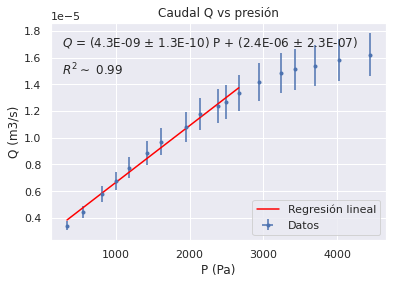

In [2]:
# Datos
T = 22 # ºC
p = 717 # mmHg
g = 9.8 # m/s^2
longitudTuboCapilar = 25 / 100 # m
densidadAgua = 1000 # kg/m^3

# Errores
errorAltura = 0.1 / 100 # m
errorMasa = 0.1 / 1000 # kg
errorTiempo = 1 # s
errorLongitudTubo = 0.1 / 100 # m

df = pd.read_csv(DATA_PATH + "datos_T22_P717.csv")

# Volumen
df["volumen agua (m3)"] = (df["masa agua recogida (g)"] / 1000) / densidadAgua
df["errorV agua (m3)"] = errorMasa / densidadAgua
# Caudal
df["Q (m3/s)"] = df["volumen agua (m3)"] / df["tiempo (s)"]
df["errorQ (m3/s)"] = (df["errorV agua (m3)"] / df["tiempo (s)"]) + abs(df["volumen agua (m3)"] * errorTiempo / (df["tiempo (s)"]**2))
# Presión
df["presion (kg/ms^2)"] = densidadAgua * g * (df["altura columna agua (cm)"] / 100)
df["errorP (kg/ms^2)"] = densidadAgua * g * errorAltura

print(tabulate(
    df, 
    headers="keys", 
    tablefmt="presto", 
    showindex=False)
)
print(" ")

x = df["presion (kg/ms^2)"].iloc[-12:]
y = df["Q (m3/s)"].iloc[-12:]
X = sm.add_constant(x, prepend=True)

ols1 = sm.OLS(y, X)
ols_result1 = ols1.fit()
print(ols_result1.summary())
print(" ")

y_pred = ols_result1.predict(X)

plt.errorbar(df["presion (kg/ms^2)"], df["Q (m3/s)"], xerr=df["errorP (kg/ms^2)"], yerr=df["errorQ (m3/s)"], fmt=".", label="Datos")
plt.plot(x, y_pred, color="red", label="Regresión lineal")
plt.title("Caudal Q vs presión")
plt.xlabel("P (Pa)")
plt.ylabel("Q (m3/s)")
plt.figtext(.15, .8, f"$Q$ = (%.1E $\pm$ %.1E) P + (%.1E $\pm$ %.1E)" % (ols_result1.params[1], ols_result1.bse[1], ols_result1.params[0], ols_result1.bse[0]))
plt.figtext(.15, .7, f"$R^2 \sim$ %.2f" % ols_result1.rsquared)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(FIGURES_PATH + "caudal_vs_presion.png")
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:               Q (m3/s)   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1012.
Date:                Fri, 27 Aug 2021   Prob (F-statistic):           2.22e-11
Time:                        20:31:57   Log-Likelihood:                 162.47
No. Observations:                  12   AIC:                            -320.9
Df Residuals:                      10   BIC:                            -320.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

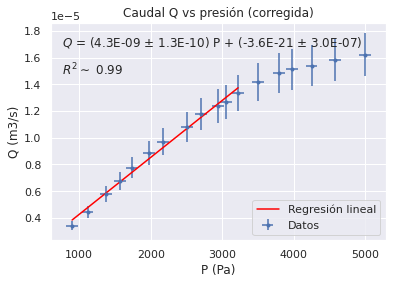

In [3]:
# Presion corregida
m = ols_result1.params[1]
b = ols_result1.params[0]
df["presion corregida (kg/ms^2)"] = df["presion (kg/ms^2)"] + (b/m)
df["errorP corregida (kg/ms^2)"] = df["errorP (kg/ms^2)"] + (ols_result1.bse[0]/m) + abs(-b * ols_result1.bse[1]/(m**2))

x = df["presion corregida (kg/ms^2)"].iloc[-12:]
y = df["Q (m3/s)"].iloc[-12:]
X = sm.add_constant(x, prepend=True)

ols1 = sm.OLS(y, X)
ols_result1 = ols1.fit()
print(ols_result1.summary())
print(" ")

y_pred = ols_result1.predict(X)

plt.errorbar(df["presion corregida (kg/ms^2)"], df["Q (m3/s)"], xerr=df["errorP corregida (kg/ms^2)"], yerr=df["errorQ (m3/s)"], fmt=".", label="Datos")
plt.plot(x, y_pred, color="red", label="Regresión lineal")
plt.title("Caudal Q vs presión (corregida)")
plt.xlabel("P (Pa)")
plt.ylabel("Q (m3/s)")
plt.figtext(.15, .8, f"$Q$ = (%.1E $\pm$ %.1E) P + (%.1E $\pm$ %.1E)" % (ols_result1.params[1], ols_result1.bse[1], ols_result1.params[0], ols_result1.bse[0]))
plt.figtext(.15, .7, f"$R^2 \sim$ %.2f" % ols_result1.rsquared)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(FIGURES_PATH + "caudal_vs_presion_corregida.png")
plt.show()

In [4]:
# Radio del tubo capilar
df2 = pd.read_csv(DATA_PATH + "tubo_capilar.csv")

df2["masa agua (kg)"] = (df2["masa vaso y tubo agua (g)"] - df2["masa vaso y tubo vacio (g)"]) / 1000

print(tabulate(
    df2, 
    headers="keys", 
    tablefmt="presto", 
    showindex=False)
)
print(" ")

radioTubo2 = df2["masa agua (kg)"].mean() / (densidadAgua * np.pi * longitudTuboCapilar)
diametroTubo = 2 * np.sqrt(radioTubo2)
# Errores en medidas de valores esperados con menos de 10 medidas
errorMasaAgua = 0.1 / 1000 # kg
if errorMasaAgua < (max(df2["masa agua (kg)"]) - min(df2["masa agua (kg)"])) / 2:
    errorMasaAgua = (max(df2["masa agua (kg)"]) - min(df2["masa agua (kg)"])) / 2 # coincide con df2["masa agua (kg)"].std()
    
errorRadioTubo2 = (1/(densidadAgua * np.pi)) * ((errorMasaAgua / longitudTuboCapilar) + abs(-df2["masa agua (kg)"].mean() * errorLongitudTubo / (longitudTuboCapilar**2)))
errorDiametro = errorRadioTubo2 / np.sqrt(radioTubo2)

print("Radio tubo capilar al cuadrado: ", radioTubo2)
print("Error radio tubo capilar al cuadrado: ", errorRadioTubo2)

   medida |   masa vaso y tubo vacio (g) |   masa vaso y tubo agua (g) |   masa agua (kg)
----------+------------------------------+-----------------------------+------------------
        1 |                        153.3 |                       155.6 |           0.0023
        2 |                        153.3 |                       155.6 |           0.0023
        3 |                        153.3 |                       155.7 |           0.0024
        4 |                        153.3 |                       155.6 |           0.0023
 
Radio tubo capilar al cuadrado:  2.96028194150923e-06
Error radio tubo capilar al cuadrado:  1.3916508223955322e-07


In [5]:
# Viscosidad dinámica mediante regresión lineal
pendiente = ols_result1.params[1] # m^4s/kg
errorPendiente = ols_result1.bse[1]

viscosidad = np.pi * radioTubo2**2 / (8 * pendiente * longitudTuboCapilar) # kg/ms
eV1 = (2 * radioTubo2 * errorRadioTubo2 / (pendiente * longitudTuboCapilar))
eV2 = abs(-(radioTubo2**2) * errorPendiente / (longitudTuboCapilar * (pendiente**2)))
eV3 = abs(-(radioTubo2**2) * errorLongitudTubo / (pendiente * (longitudTuboCapilar**2)))
errorViscosidad = (np.pi/8) * (eV1 + eV2 + eV3)

print("Viscosidad teórica (Pas): ", 0.001)
print("Viscosidad dinámica (kg/ms) experimental: ", viscosidad)
print("Error viscosidad dinámica (kg/ms) experimental: ", errorViscosidad)

Viscosidad teórica (Pas):  0.001
Viscosidad dinámica (kg/ms) experimental:  0.0032270807445368634
Error viscosidad dinámica (kg/ms) experimental:  0.000417790576272693


In [6]:
# Velocidad media y número de Reynolds
df["U"] = df["Q (m3/s)"] / (np.pi * radioTubo2)
df["errorU"] = (df["errorQ (m3/s)"] / (np.pi * radioTubo2)) + abs(-df["Q (m3/s)"] * errorRadioTubo2 / (np.pi* (radioTubo2**2)))
df["Re pendiente"] = df["U"] * densidadAgua * diametroTubo / viscosidad

eRe1 = densidadAgua * diametroTubo * df["errorU"] / viscosidad
eRe2 = df["U"] * densidadAgua * errorDiametro / viscosidad
eRe3 = abs(- df["U"] * densidadAgua * diametroTubo * errorViscosidad / (viscosidad**2))
df["errorRe pendiente"] = eRe1 + eRe2 + eRe3

df["visco (extra)"] = (np.pi * (radioTubo2**2) * df["presion corregida (kg/ms^2)"]) / (8 * df["Q (m3/s)"] * longitudTuboCapilar)
df["Re visco (extra)"] = df["U"] * densidadAgua * diametroTubo / df["visco (extra)"]

df

,altura columna agua (cm),masa agua recogida (g),tiempo (s),volumen agua (m3),errorV agua (m3),Q (m3/s),errorQ (m3/s),presion (kg/ms^2),errorP (kg/ms^2),presion corregida (kg/ms^2),errorP corregida (kg/ms^2),U,errorU,Re pendiente,errorRe pendiente,visco (extra),Re visco (extra)
0,45.3,162.4,10,0.000162,1.000000e-07,0.000016,1.634000e-06,4439.4,9.8,4996.623585,81.445028,1.746237,0.257791,1862.043309,559.722452,0.004235,1418.805857
1,41.0,158.3,10,0.000158,1.000000e-07,0.000016,1.593000e-06,4018.0,9.8,4575.223585,81.445028,1.702151,0.251310,1815.033595,545.620475,0.003978,1472.234748
2,37.7,154.0,10,0.000154,1.000000e-07,0.000015,1.550000e-06,3694.6,9.8,4251.823585,81.445028,1.655914,0.244512,1765.730724,530.830597,0.003800,1499.318022
3,34.9,151.2,10,0.000151,1.000000e-07,0.000015,1.522000e-06,3420.2,9.8,3977.423585,81.445028,1.625806,0.240086,1733.626529,521.199978,0.003621,1545.002882
4,33.0,148.7,10,0.000149,1.000000e-07,0.000015,1.497000e-06,3234.0,9.8,3791.223585,81.445028,1.598925,0.236134,1704.962069,512.601211,0.003510,1567.725765
5,30.0,142.0,10,0.000142,1.000000e-07,0.000014,1.430000e-06,2940.0,9.8,3497.223585,81.445028,1.526882,0.225543,1628.141317,489.556517,0.003390,1549.818521
6,27.2,133.4,10,0.000133,1.000000e-07,0.000013,1.344000e-06,2665.6,9.8,3222.823585,81.445028,1.434409,0.211949,1529.535575,459.976760,0.003326,1484.235047
7,25.5,127.0,10,0.000127,1.000000e-07,0.000013,1.280000e-06,2499.0,9.8,3056.223585,81.445028,1.365591,0.201832,1456.154558,437.963918,0.003313,1418.567074
8,24.3,123.9,10,0.000124,1.000000e-07,0.000012,1.249000e-06,2381.4,9.8,2938.623585,81.445028,1.332258,0.196932,1420.610628,427.301448,0.003265,1404.191078
9,21.9,118.0,10,0.000118,1.000000e-07,0.000012,1.190000e-06,2146.2,9.8,2703.423585,81.445028,1.268817,0.187605,1352.962503,407.008359,0.003154,1384.450628


In [7]:
# Coeficiente de resistencia

df["lambda"] = diametroTubo * df["presion corregida (kg/ms^2)"] / (longitudTuboCapilar * .5 * densidadAgua * (df["U"]**2))
eLambda1 = 2 * df["presion corregida (kg/ms^2)"] * errorDiametro / (longitudTuboCapilar * densidadAgua * (df["U"]**2))
eLambda2 = 2 * diametroTubo * df["errorP corregida (kg/ms^2)"] / (longitudTuboCapilar * densidadAgua * (df["U"]**2))
eLambda3 = abs(- 2 * diametroTubo * df["presion corregida (kg/ms^2)"] * errorLongitudTubo / (densidadAgua * (longitudTuboCapilar**2) * (df["U"]**2)))
eLambda4 = abs(- 4 * diametroTubo * df["presion corregida (kg/ms^2)"] * df["U"] * df["errorU"] / (longitudTuboCapilar * densidadAgua * (df["U"]**4)))
df["errorLambda"] = eLambda1 + eLambda2 + eLambda3 + eLambda4

df["lambda64"] = 64 / df["Re pendiente"]
df["errorLambda64"] = abs(- 64 * df["errorRe pendiente"] / (df["Re pendiente"]**2))

df["lambda64 (extra)"] = 64 / df["Re visco (extra)"]

df

,altura columna agua (cm),masa agua recogida (g),tiempo (s),volumen agua (m3),errorV agua (m3),Q (m3/s),errorQ (m3/s),presion (kg/ms^2),errorP (kg/ms^2),presion corregida (kg/ms^2),...,errorU,Re pendiente,errorRe pendiente,visco (extra),Re visco (extra),lambda,errorLambda,lambda64,errorLambda64,lambda64 (extra)
0,45.3,162.4,10,0.000162,1.000000e-07,0.000016,1.634000e-06,4439.4,9.8,4996.623585,...,0.257791,1862.043309,559.722452,0.004235,1418.805857,0.045108,0.015294,0.034371,0.010332,0.045108
1,41.0,158.3,10,0.000158,1.000000e-07,0.000016,1.593000e-06,4018.0,9.8,4575.223585,...,0.251310,1815.033595,545.620475,0.003978,1472.234748,0.043471,0.014806,0.035261,0.010600,0.043471
2,37.7,154.0,10,0.000154,1.000000e-07,0.000015,1.550000e-06,3694.6,9.8,4251.823585,...,0.244512,1765.730724,530.830597,0.003800,1499.318022,0.042686,0.014598,0.036246,0.010896,0.042686
3,34.9,151.2,10,0.000151,1.000000e-07,0.000015,1.522000e-06,3420.2,9.8,3977.423585,...,0.240086,1733.626529,521.199978,0.003621,1545.002882,0.041424,0.014222,0.036917,0.011099,0.041424
4,33.0,148.7,10,0.000149,1.000000e-07,0.000015,1.497000e-06,3234.0,9.8,3791.223585,...,0.236134,1704.962069,512.601211,0.003510,1567.725765,0.040823,0.014058,0.037537,0.011286,0.040823
5,30.0,142.0,10,0.000142,1.000000e-07,0.000014,1.430000e-06,2940.0,9.8,3497.223585,...,0.225543,1628.141317,489.556517,0.003390,1549.818521,0.041295,0.014297,0.039309,0.011819,0.041295
6,27.2,133.4,10,0.000133,1.000000e-07,0.000013,1.344000e-06,2665.6,9.8,3222.823585,...,0.211949,1529.535575,459.976760,0.003326,1484.235047,0.043120,0.015019,0.041843,0.012583,0.043120
7,25.5,127.0,10,0.000127,1.000000e-07,0.000013,1.280000e-06,2499.0,9.8,3056.223585,...,0.201832,1456.154558,437.963918,0.003313,1418.567074,0.045116,0.015779,0.043951,0.013219,0.045116
8,24.3,123.9,10,0.000124,1.000000e-07,0.000012,1.249000e-06,2381.4,9.8,2938.623585,...,0.196932,1420.610628,427.301448,0.003265,1404.191078,0.045578,0.015991,0.045051,0.013551,0.045578
9,21.9,118.0,10,0.000118,1.000000e-07,0.000012,1.190000e-06,2146.2,9.8,2703.423585,...,0.187605,1352.962503,407.008359,0.003154,1384.450628,0.046228,0.016334,0.047304,0.014230,0.046228


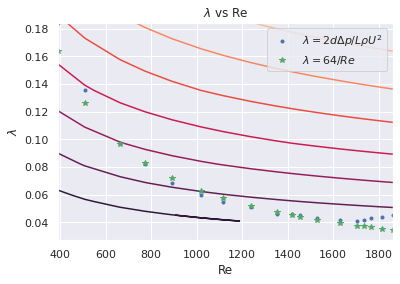

In [8]:
x = df["Re pendiente"].to_numpy()
y = df["lambda"].to_numpy()
y1 = df["lambda64"].to_numpy()

#plt.errorbar(x, y, xerr=df["errorRe pendiente"], yerr=df["errorLambda"], fmt=".", label=r"$\lambda = 2d \Delta p / L\rho U^2$")
plt.plot(x, y, "b.", label=r"$\lambda = 2d \Delta p / L\rho U^2$")
#plt.errorbar(x, y1, xerr=df["errorRe pendiente"], yerr=df["errorLambda64"], fmt=".", label="$\lambda = 64/Re$")
plt.plot(x, y1, "g*", label="$\lambda = 64/Re$")

X, Y = np.meshgrid(x, y)
plt.contour(X, Y, (np.sqrt(Y) * 2 * np.log10(X * np.sqrt(Y)) - 0.8 * np.sqrt(Y)) - 1)

plt.title("$\lambda$ vs Re")
plt.xlabel("Re")
plt.ylabel("$\lambda$")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(FIGURES_PATH + "3lambda_nolog_noerror.png")
plt.show()

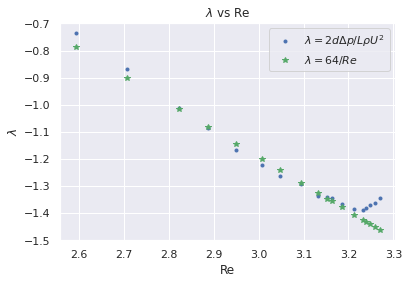

In [9]:
#plt.errorbar(np.log10(x), np.log10(y), xerr=df["errorRe pendiente"]/df["Re pendiente"], yerr=df["errorLambda"]/df["lambda"], fmt=".", label=r"$\lambda = 2d \Delta p / L\rho U^2$")
#plt.errorbar(np.log10(x), np.log10(y1), xerr=df["errorRe pendiente"]/df["Re pendiente"], yerr=df["errorLambda64"]/df["lambda64"], fmt=".", label="$\lambda = 64/Re$")

plt.plot(np.log10(x), np.log10(y), "b.", label=r"$\lambda = 2d \Delta p / L\rho U^2$")
plt.plot(np.log10(x), np.log10(y1), "g*", label="$\lambda = 64/Re$")

plt.title("$\lambda$ vs Re")
plt.xlabel("Re")
plt.ylabel("$\lambda$")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(FIGURES_PATH + "2lambda_log_noerror.png")
plt.show()

In [10]:
df_table = df[[
    "Q (m3/s)",
    "errorQ (m3/s)",
    "presion corregida (kg/ms^2)",
    "errorP corregida (kg/ms^2)",
    "U",
    "errorU",
    "Re pendiente",
    "errorRe pendiente",
    "lambda",
    "errorLambda",
    "lambda64",
    "errorLambda64"
]]

print(tabulate(
    df_table, 
    headers="keys", 
    tablefmt="presto", 
    showindex=False)
)

   Q (m3/s) |   errorQ (m3/s) |   presion corregida (kg/ms^2) |   errorP corregida (kg/ms^2) |        U |    errorU |   Re pendiente |   errorRe pendiente |    lambda |   errorLambda |   lambda64 |   errorLambda64
------------+-----------------+-------------------------------+------------------------------+----------+-----------+----------------+---------------------+-----------+---------------+------------+-----------------
  1.624e-05 |       1.634e-06 |                      4996.62  |                       81.445 | 1.74624  | 0.257791  |       1862.04  |             559.722 | 0.0451084 |     0.0152944 |  0.0343708 |       0.0103317
  1.583e-05 |       1.593e-06 |                      4575.22  |                       81.445 | 1.70215  | 0.25131   |       1815.03  |             545.62  | 0.0434713 |     0.014806  |  0.0352611 |       0.0105999
  1.54e-05  |       1.55e-06  |                      4251.82  |                       81.445 | 1.65591  | 0.244512  |       1765.73  |         